In [ ]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd

pd.set_option("mode.chained_assignment", None)
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline as backend_inline

backend_inline.set_matplotlib_formats("svg")

# Uciml repo
from ucimlrepo import fetch_ucirepo

# Pytorch device specific configuration
# Pytorch Gpu Configuration for cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Pytorch Gpu Configuration for dml devices
# import torch_directml

# device = torch_directml.device()

# Set default devices
torch.set_default_device(device)

In [158]:
# Import heart desease data
heart_disease = fetch_ucirepo(id=45)

# Data as pandas dataframe
data = heart_disease.data.features
labels = heart_disease.data.targets

In [159]:
#### Data pre-processing ####
# Filling nan values with it's mean
keys = data.keys()
for key in keys:
    # print(f"{key} before filling na count: {data[key].isna().sum()}")
    data[key] = data[key].fillna(data[key].mean())
    # print(f"{key} after filling na count: {data[key].isna().sum()}")

# Binarized labels
labels = labels.values > 0
data = data.values
print(data.shape, labels.shape)

(303, 13) (303, 1)


In [160]:
# Data normalization
data = data / np.max(data)
# convert data into tensors
dataT = torch.tensor(data).float()
labelsT = torch.tensor(labels).float()

# Train test split
train_data, test_data, train_labels, test_labels = train_test_split(
    dataT, labelsT, train_size=0.8
)
# Data over sampling
train_data = torch.concat((train_data, train_data))
train_labels = torch.concat((train_labels, train_labels))
# Pytorch datasets
train_dataT = TensorDataset(train_data, train_labels)
test_dataT = TensorDataset(test_data, test_labels)

# Lead data into data loaders
batchSize = 8
train_loader = DataLoader(
    train_dataT,
    batch_size=batchSize,
    shuffle=True,
    drop_last=True,
    generator=torch.Generator(device),
)
test_loader = DataLoader(
    test_dataT,
    batch_size=test_dataT.tensors[0].shape[0],
    generator=torch.Generator(device),
)

In [ ]:
def createTheModel():
    class PredictHeartDisease(nn.Module):
        def __init__(self):
            super().__init__()

            self.dr = 0.5
            # Input Layer
            self.input = nn.Linear(13, 64)
            # Hidden Layers
            self.hidden1 = nn.Linear(64, 256)
            self.hidden2 = nn.Linear(256, 512)
            self.hidden3 = nn.Linear(512, 256)
            self.hidden4 = nn.Linear(256, 128)
            self.hidden5 = nn.Linear(128, 16)
            # Output Layers
            self.output = nn.Linear(16, 1)

        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.dropout(x, p=self.dr, training=self.training)
            x = F.relu(self.hidden1(x))
            x = F.dropout(x, p=self.dr, training=self.training)
            x = F.relu(self.hidden2(x))
            x = F.dropout(x, p=self.dr, training=self.training)
            x = F.relu(self.hidden3(x))
            x = F.dropout(x, p=self.dr, training=self.training)
            x = F.relu(self.hidden4(x))
            x = F.dropout(x, p=self.dr, training=self.training)
            x = F.relu(self.hidden5(x))
            x = F.dropout(x, p=self.dr, training=self.training)
            return self.output(x)

    net = PredictHeartDisease()

    # Loss Function
    lossFun = nn.BCEWithLogitsLoss()

    # Optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

    return net, lossFun, optimizer

In [162]:
# Test the model for errors
net, lossFun, optimizer = createTheModel()
tempData = torch.randint(low=-1, high=2, size=(100, 13)).float()
net(tempData)

tensor([[-3.6058e-02],
        [ 4.9452e-02],
        [-1.8430e-02],
        [ 6.3630e-02],
        [ 1.0457e-01],
        [-1.8658e-02],
        [-1.4393e-03],
        [-9.6556e-02],
        [-5.2927e-02],
        [ 4.2761e-03],
        [ 5.7231e-03],
        [-2.7535e-02],
        [ 1.5839e-02],
        [ 1.7646e-03],
        [ 5.7057e-03],
        [ 1.5383e-02],
        [ 2.2037e-02],
        [ 4.4000e-03],
        [-1.6515e-02],
        [-1.6520e-02],
        [ 1.3816e-03],
        [ 8.2634e-03],
        [-2.3453e-02],
        [-1.7774e-02],
        [-1.8252e-02],
        [-3.3552e-02],
        [-5.3794e-02],
        [ 4.0677e-02],
        [ 2.6936e-02],
        [-1.4743e-02],
        [ 7.6862e-02],
        [-8.2989e-03],
        [-2.2105e-03],
        [-1.7236e-03],
        [ 7.7639e-03],
        [-2.0558e-02],
        [-3.0721e-02],
        [-2.5957e-02],
        [ 2.6644e-02],
        [ 1.6401e-02],
        [-3.2154e-02],
        [ 3.6523e-02],
        [ 3.4240e-02],
        [ 2

In [ ]:
# Train the model function
def trainTheModel(nEpochs):

    # Loss and accuracy initialization
    trainAcc = []
    testAcc = []
    losses = np.zeros(nEpochs)

    # The Loop
    for epoch in range(nEpochs):
        print(f"Training epoch: {epoch}")
        # Model in training model
        net.train()

        # Batch accuracy and loss
        batchAcc = []
        batchLoss = []

        for X, y in train_loader:

            # Forward pass
            yHat = net(X)
            loss = lossFun(yHat, y)
            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # Accuracies
            batchAcc.append(
                100
                * torch.mean((((torch.sigmoid(yHat) > 0.5).float()) == y).float()).cpu()
            )
            batchLoss.append(loss.cpu().item())

        # Batch Loop finished
        # Training loss and accuracy
        trainAcc.append(np.mean(batchAcc))
        losses[epoch] = np.mean(batchLoss)

        # Evaluate the model performance
        net.eval()
        X, y = next(iter(test_loader))
        with torch.no_grad():
            yHat = net(X)
        testAcc.append(
            100 * torch.mean((((torch.sigmoid(yHat) > 0.5).float()) == y).float()).cpu()
        )

    return trainAcc, testAcc, losses

In [168]:
net, lossFun, optimizer = createTheModel()
nEpochs = 500
trainAcc, testAcc, losses = trainTheModel(nEpochs=nEpochs)

Training epoch: 0
Training epoch: 1
Training epoch: 2
Training epoch: 3
Training epoch: 4
Training epoch: 5
Training epoch: 6
Training epoch: 7
Training epoch: 8
Training epoch: 9
Training epoch: 10
Training epoch: 11
Training epoch: 12
Training epoch: 13
Training epoch: 14
Training epoch: 15
Training epoch: 16
Training epoch: 17
Training epoch: 18
Training epoch: 19
Training epoch: 20
Training epoch: 21
Training epoch: 22
Training epoch: 23
Training epoch: 24
Training epoch: 25
Training epoch: 26
Training epoch: 27
Training epoch: 28
Training epoch: 29
Training epoch: 30
Training epoch: 31
Training epoch: 32
Training epoch: 33
Training epoch: 34
Training epoch: 35
Training epoch: 36
Training epoch: 37
Training epoch: 38
Training epoch: 39
Training epoch: 40
Training epoch: 41
Training epoch: 42
Training epoch: 43
Training epoch: 44
Training epoch: 45
Training epoch: 46
Training epoch: 47
Training epoch: 48
Training epoch: 49
Training epoch: 50
Training epoch: 51
Training epoch: 52
Tra

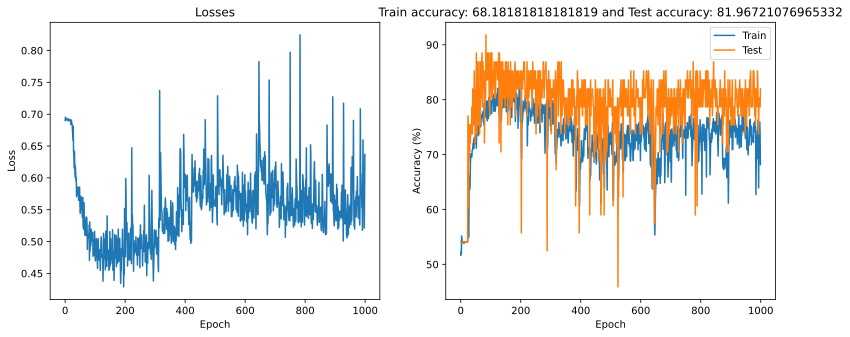

In [ ]:
# Plot the result
fig, ax = plt.subplots(1, 2, figsize=(13, 5))

ax[0].plot(losses)
ax[0].set_ylabel("Loss")
ax[0].set_xlabel("Epoch")
ax[0].set_title("Losses")

ax[1].plot(trainAcc, label="Train")
ax[1].plot(testAcc, label="Test")
ax[1].set_ylabel("Accuracy (%)")
ax[1].set_xlabel("Epoch")
ax[1].set_title(f"Train accuracy: {trainAcc[-1]} and Test accuracy: {testAcc[-1]}")
ax[1].legend()
plt.show()

plt.show()